In [0]:
try:
  import tflearn # try to import tflearn
except ImportError:
  !pip3 install -q tflearn # install tflearn first
  import tflearn # then import it

In [0]:
import matplotlib.pyplot as plt # used for plotting images
import numpy as np # to do math functions
import os, sys # to interact with filesystem
import tensorflow as tf # tensorflow during training
from tflearn.activations import relu # rectified linear activation function

# normalizes data
from tflearn.layers.normalization import batch_normalization as bn
from scipy.misc import imread, bytescale, imresize # image manipulation functions
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, global_avg_pool
from tflearn.layers.estimator import regression # trainer for the network

# turns scalar label into vector where appropriate class is value 1 and others 0
from tflearn.data_utils import to_categorical 

# makes new images from the ones we have by flipping them, rotation, etc.
from tflearn.data_augmentation import ImageAugmentation

# to visualize the data
from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
def install_tensorboard_dep():
  '''Installs tensorboard to be used in colab'''
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def montage(x, plot_shape=(15, 15), return_grid=False, cmap='viridis'):
  '''
  Takes in a 4-D tensor, x, of shape [NxHxWxC] and puts all of the images
  together in a single matrix to show as one image. If return_grid is True, 
  it will not show the matrix, but return it to be used in some other 
  operations.
  '''
  
  count = 0
  if not return_grid:
    scale = [0, 255]
  else:
    scale = [0, 1]
  
  
  if len(x.shape) == 4 and x.shape[-1] == 3:
    num, m, n, c = x.shape
  else:
    num, m, n = x.shape
    c = 1
    
  num = int(np.ceil(np.sqrt(num)))
  grid = np.zeros([num*m, num*n, c])
  
  if c == 1:
    grid = grid[..., 0]
  
  for i in range(num):
    for j in range(num):
      if count < x.shape[0]:
        if c == 1:
          grid[i*m:i*m+m, j*n:j*n+n] = bytescale(x[count, ...], 
                                                 low=scale[0], high=scale[1])
        else:
          grid[i*m:i*m+m, j*n:j*n+n, :] = bytescale(x[count, ...],
                                                    low=scale[0], high=scale[1])
        count += 1 
        
  if return_grid:
    return grid
  else:
    fig = plt.figure(figsize=plot_shape)
    a1 = fig.add_subplot(111)
    a1.set_xticks(np.arange(-0.5, num*n, n))
    a1.set_yticks(np.arange(-0.5, num*m, m))
    a1.set_yticklabels([])
    a1.set_xticklabels([])
    a1.imshow(grid, cmap=cmap)
    plt.show()

In [0]:
def start_tensorboard():
  LOG_DIR = '/tmp/tflearn_logs'
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
def viz_embedding(tensor, images, labels, shape):
  
  tb_dir = '/tmp/tflearn_logs'
  sess = tf.Session()
  sess.run(tensor.initializer)
  summary_writer = tf.summary.FileWriter(tb_dir)
  config = projector.ProjectorConfig()
  embedding = config.embeddings.add()
  embedding.tensor_name = tensor.name
  embedding.metadata_path = os.path.join(tb_dir, 'metadata.tsv')
  embedding.sprite.image_path = os.path.join(tb_dir, 'flowers.png') 
  embedding.sprite.single_image_dim.extend(shape)
  projector.visualize_embeddings(summary_writer, config)
  saver = tf.train.Saver([tensor])
  saver.save(sess, os.path.join(tb_dir, 'flowers.ckpt'), 1)
  
  image_grid = montage(images, return_grid=True)
  plt.imsave(os.path.join(tb_dir, 'flowers.png'), image_grid)
  
  with open(os.path.join(tb_dir, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(labels):
      f.write("%d\t%d\n" % (index,label))
  f.close()

In [97]:
response = input('Do you want to train a network? (y/n) ') # ask user if they want to train or load

# if input was Y, y, Yes, or Yes, Train Network. If not, load a trained one.
if response is ['Y', 'y', 'Yes', 'yes']:
  Train = True
else:
  Train = False

Do you want to train a network? (y/n) y


In [98]:
print(Train)

False


In [0]:
# import dataset loader from tflearn
import tflearn.datasets.oxflower17 as oxflower17

# load the data in as X and the labels in as Y
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(150, 150))

In [100]:
print(X.shape, Y.shape) # print the shape of data and labels
print(Y[:10, ...]) # print first 10 label vectors

(1360, 150, 150, 3) (1360, 17)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


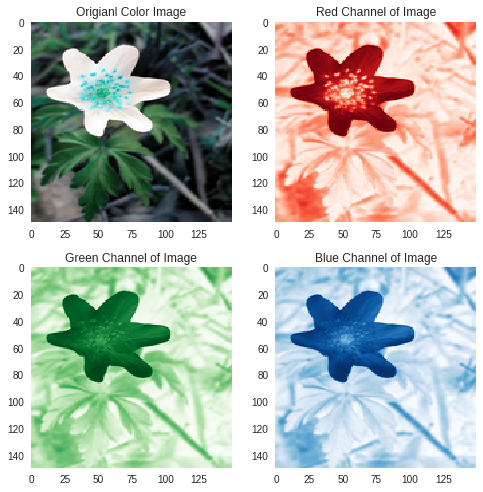

In [101]:
fig = plt.figure(figsize=(7,7)) # create a figure of size 7x7
a1 = fig.add_subplot(221) # add the first of four subplots in the figure
a2 = fig.add_subplot(222) # add the second of four subplots in the figure
a3 = fig.add_subplot(223) # add the third subplot
a4 = fig.add_subplot(224) # add the fourth subplot

x_show = X[0, :, :, ::-1] # get the first image from the dataset

a1.imshow(bytescale(x_show)) # show the original image
a2.imshow(x_show[..., 0], cmap='Reds') # shows the first color channel (red) of the image
a3.imshow(x_show[..., 1], cmap='Greens') # show the second color channel (green) of the image
a4.imshow(x_show[..., 2], cmap='Blues') # show the third color channel (blue) of the image

# remove the grid and tick lines
a1.grid(False)
a2.grid(False)
a3.grid(False)
a4.grid(False)

a1.set_title('Origianl Color Image')
a2.set_title('Red Channel of Image')
a3.set_title('Green Channel of Image')
a4.set_title('Blue Channel of Image')

plt.tight_layout() # helps organize figure if there are many subplots

In [102]:
montage(X[..., ::-1], (18, 18))

In [0]:
random_img = X[100, ...] # take the 100th image from the dataset
weight_filter = np.random.randn(5, 5, 3)  # make random weights
output_feature_map = np.zeros([random_img.shape[0], random_img.shape[1]])  # create empty feature map

In [0]:
for i in range(random_img.shape[0]-5):  # loop through rows
  for j in range(random_img.shape[0]-5):  # loop through columns
    output_feature_map[i, j] = np.sum(weight_filter * random_img[i:i+5, j:j+5, :]) # weighted sum

In [105]:
print(np.amax(output_feature_map), np.amin(output_feature_map))

4.878621680377245 -5.4849931049327605


In [0]:
output_feature_map = bytescale(output_feature_map)

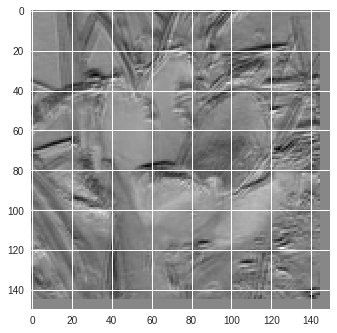

In [107]:
plt.imshow(output_feature_map, cmap='gray')

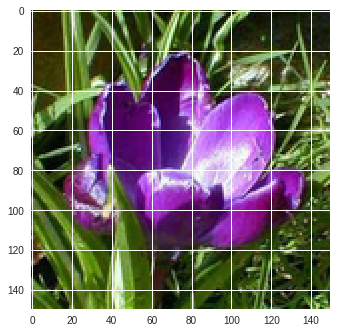

In [108]:
plt.imshow(random_img)

In [0]:
# make negative activation values 0 and keep positive ones - rectified linear activation
output_feature_map = np.int32(output_feature_map > 0) * output_feature_map

In [110]:
print(output_feature_map.shape)

(150, 150)


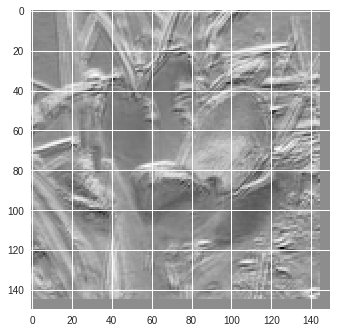

In [111]:
plt.imshow(np.float32(output_feature_map))

(array([2515748., 1970901., 1271388., 1831295., 1176952., 1750327.,
        1154911., 1727703., 1163294., 1716089., 1713582., 1138158.,
        1696632., 1133004., 1683842., 1110720., 1658613., 1105884.,
        1650764., 1078074., 1597916., 1584430., 1039727., 1540190.,
        1009702., 1501586.,  994556., 1476760.,  970707., 1433303.,
        1406113.,  922733., 1357350.,  888378., 1310056.,  866204.,
        1277732.,  836260., 1235241.,  808561., 1190542., 1170592.,
         768601., 1128441.,  732964., 1074155.,  701244., 1024838.,
         669354.,  974687.,  949644.,  622067.,  908548.,  593716.,
         877349.,  573999.,  850167.,  562083.,  820562.,  536725.,
         791542.,  778159.,  510491.,  757984.,  499769.,  741845.,
         489462.,  728432.,  485462.,  710574.,  702556.,  461258.,
         679423.,  445237.,  659305.,  431860.,  639862.,  422443.,
         631124.,  409200.,  620001.,  608083.,  390823.,  573901.,
         386288.,  544991.,  357308.,  525271., 

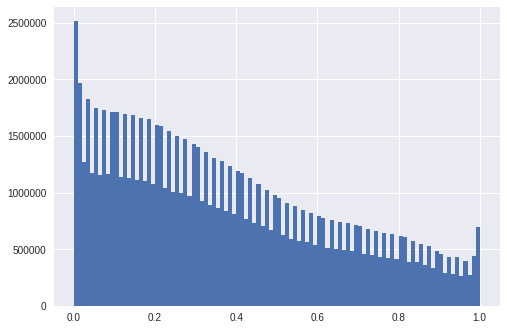

In [112]:
plt.hist(X.flatten(), bins=100) # view histogram of raw data

In [0]:
# preprocess by subtracting mean and dividing by standard deviation
X -= np.mean(X, 0) # center each pixel value around 0
X /= np.std(X, 0)  # squash each pixel to between -1 and 1

(array([8.500000e+02, 5.138000e+03, 1.051000e+04, 2.470000e+04,
        4.701500e+04, 7.110500e+04, 9.616600e+04, 1.266000e+05,
        1.608490e+05, 2.050810e+05, 2.684020e+05, 3.692040e+05,
        5.376410e+05, 7.226660e+05, 9.138750e+05, 1.098724e+06,
        1.186553e+06, 1.318418e+06, 1.722880e+06, 2.431520e+06,
        3.097663e+06, 2.965132e+06, 2.831172e+06, 2.743237e+06,
        2.668498e+06, 2.606052e+06, 2.552093e+06, 2.489256e+06,
        2.438241e+06, 2.380057e+06, 2.328377e+06, 2.275063e+06,
        2.218959e+06, 2.155295e+06, 2.095437e+06, 2.036040e+06,
        1.980998e+06, 1.921062e+06, 1.863719e+06, 1.814753e+06,
        1.759499e+06, 1.701709e+06, 1.643059e+06, 1.590097e+06,
        1.539051e+06, 1.487747e+06, 1.440076e+06, 1.396599e+06,
        1.358025e+06, 1.313808e+06, 1.274272e+06, 1.231576e+06,
        1.187724e+06, 1.147263e+06, 1.104266e+06, 1.068359e+06,
        1.030891e+06, 9.920100e+05, 9.207130e+05, 8.449340e+05,
        7.750840e+05, 6.923470e+05, 6.37

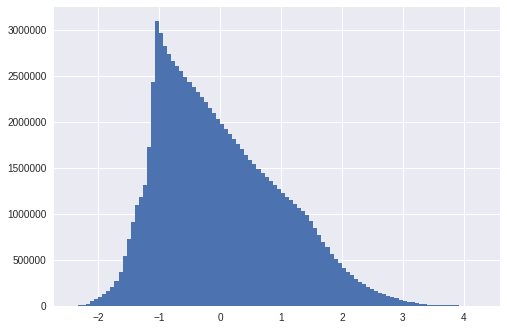

In [114]:
plt.hist(X.flatten(), bins=100) # view histogram of normalized data

In [115]:
print(np.mean(X), np.std(X))

-9.992398e-07 0.9999991


In [0]:
tf.reset_default_graph() # reset the tensorflow graph# augment images 
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()  # randomly flip some images left to right
img_aug.add_random_rotation(max_angle=33.)  # randomly rotate images up to 33 degrees
img_aug.add_random_crop((150, 150), padding=15)  # randomly crop a 120 x 120 frame out of images

In [0]:
# create a layer to view data space in tensorboard
emb = tf.Variable(X[::10, ...], name='input_flower_images')

In [0]:
# tflearn documentation --- http://tflearn.org/

# create input layer that takes in images and augments them as well
in_layer = input_data(shape=[None, 150, 150, 3], data_augmentation=img_aug)

# have 64, 7x7 filters slide over the input images
conv1 = conv_2d(in_layer, 64, 7, activation='linear', name='c1')

# normalize conv1 layer feature maps
batch_norm1 = bn(conv1, name='bn1')

# perform relu activation function
relu1 = relu(batch_norm1)

# max pooling 
pool1 = max_pool_2d(relu1, 3, 2)

# second conv layer with 128, 3x3 filters
conv2 = conv_2d(pool1, 128, 3, activation='linear', name='c2')

# second normalization layer
batch_norm2 = bn(conv2, name='bn2')

# second relu layer
relu2 = relu(batch_norm2)

# max pooling layer 2
pool2 = max_pool_2d(relu2, 3, 2)

# conv3 layer
conv3 = conv_2d(pool2, 256, 3, activation='linear', name='c3')

# normalize c3 layer
batch_norm3 = bn(conv3, name='bn3')

# relu on normalized c3 heat maps --- num_images x 37 x 37 x 256
relu3 = relu(batch_norm3)

# take the average of each of the 256 feature maps --- num_images x 1 x 1 x 256
gap = global_avg_pool(relu3)

# output layer --- softmax turns output values into probabilities
out_layer = fully_connected(gap, 17, activation='softmax', name='fc')

In [0]:
# describe how to optimize the network's weights
network = regression(out_layer, optimizer='adam', 
                     loss='categorical_crossentropy', learning_rate=.001)

In [0]:
# build the network based on the description above
model = tflearn.DNN(network, tensorboard_verbose=2)

In [121]:
# name for tensorboard 
tensorboard_name = 'flowers_cnn'

# send the visualization layer to tensorboard via our function
viz_embedding(emb, X[::10, ...], np.argmax(Y[::10, ...], 1), [150, 150, 3])

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'ImageAugmentation' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'dict' object has no attribute 'name'


In [122]:
# start tensorboard --- might need to run this code cell twice
install_tensorboard_dep()
start_tensorboard()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [0]:
if Train:
  model.fit(X, # input data
            Y, # corresponding labels
            n_epoch=50, # number of times to go through entire dataset
            shuffle=True,   # shuffle the images each epoch
            validation_set=0.1,  # use 10% for validation
            show_metric=True, # show validation accuracy/loss in tensorboard
            batch_size=50,   # go through dataset 50 examples at a time
            run_id='OxfordFlowers_CNN')  # name that will show up on tensorboard
  
  # saved the trained model for later as the name in red
  model.save('flowers_CNN')

In [0]:
sess = tf.Session()  # tensorflow session
sess.run(tf.global_variables_initializer())

In [0]:
def load_layer(layer_name, data):
  '''A function to retrieve feature maps with name layer_name
     from the model given input data. '''
  layer = sess.run(layer_name, {in_layer:data[None, ...]})
  print(layer.shape)
  return layer

In [0]:
def view_feature_map(layer):
  '''Takes in feature maps of shape NHWC and plots every one using 
     the montage function.'''
  n, h, w, c = layer.shape # get layer's shape
  layer = layer.transpose((0, 3, 1, 2)).reshape([n*c, h, w])
  montage(layer, cmap='gray')

In [0]:
# choose 1 random number between 0 and the number of examples in the dataset
random_index = np.random.randint(0, X.shape[0], 1)[0]

# take out the image at that spot to use 
new_img = X[random_index, ...]

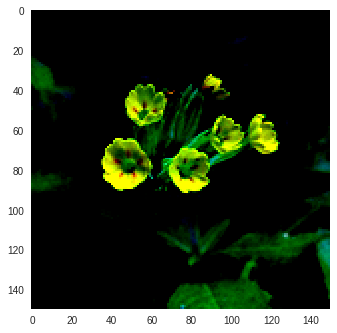

In [128]:
# view the original image
img_show = bytescale(new_img, 0, 1) # make values in new_img go between 0 and 1 to show it in matplotlib
plt.imshow(img_show)  # tell it what to show
plt.grid(False)  # get rid of the gridlines since this is not a graph
plt.show()  # show the image

(1, 150, 150, 64)


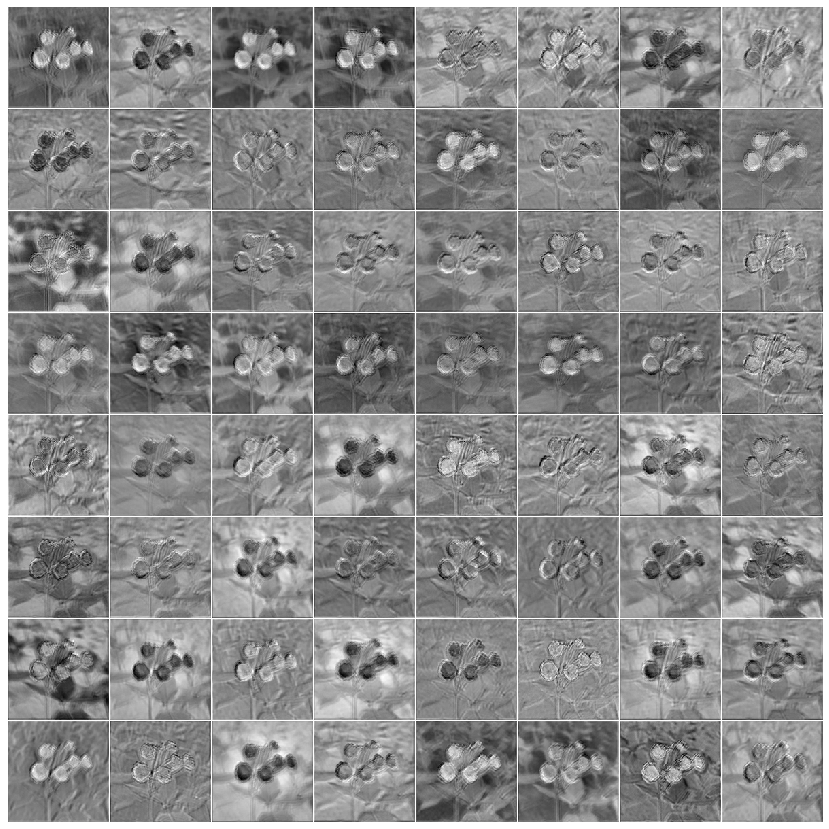

In [129]:
# view the first conv layer's feature maps --- 64 different views of the image to help decide what it is
view_feature_map(load_layer(conv1, new_img))

(1, 150, 150, 64)


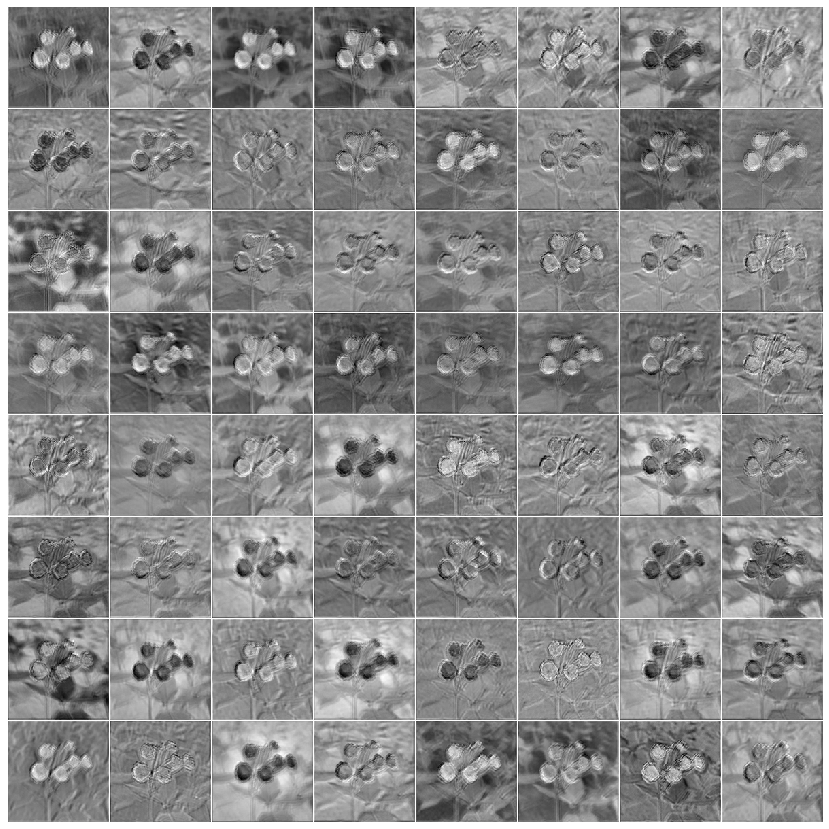

In [130]:
# view results of the normalization layer
view_feature_map(load_layer(batch_norm1, new_img))

(1, 150, 150, 64)


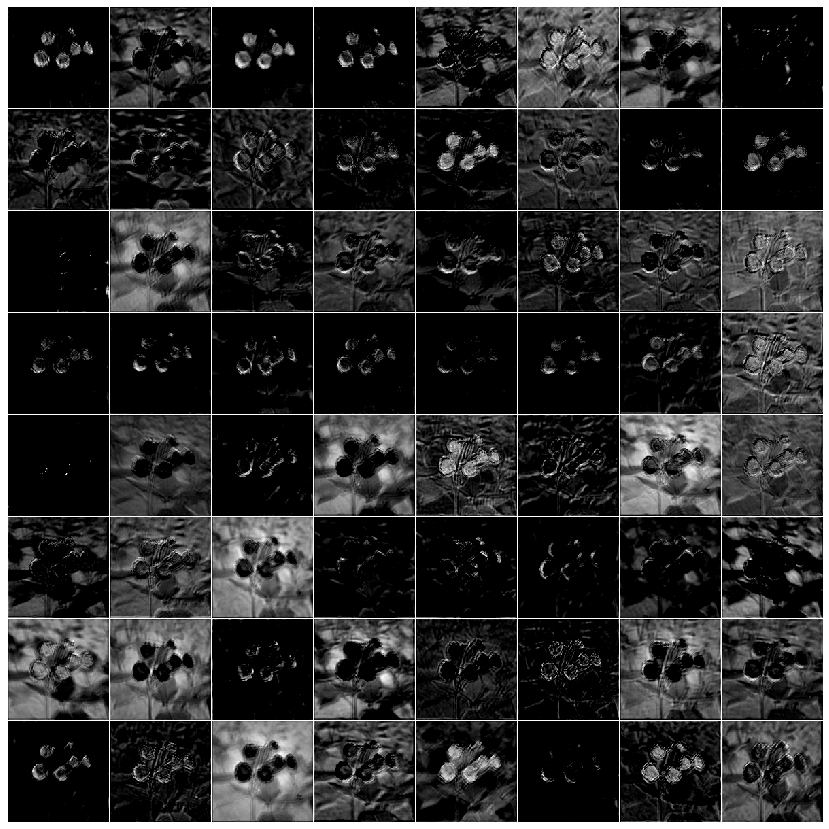

In [131]:
# view results of the rectified linear layer
view_feature_map(load_layer(relu1, new_img))

(1, 75, 75, 64)


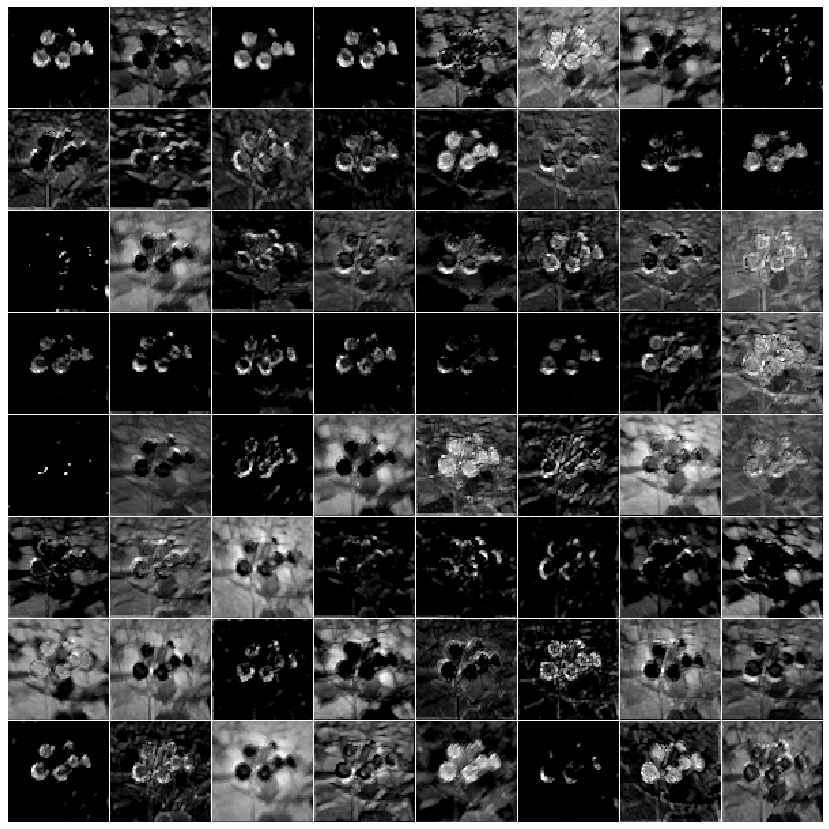

In [132]:
# view results of the pooling layer
view_feature_map(load_layer(pool1, new_img))

(1, 75, 75, 128)


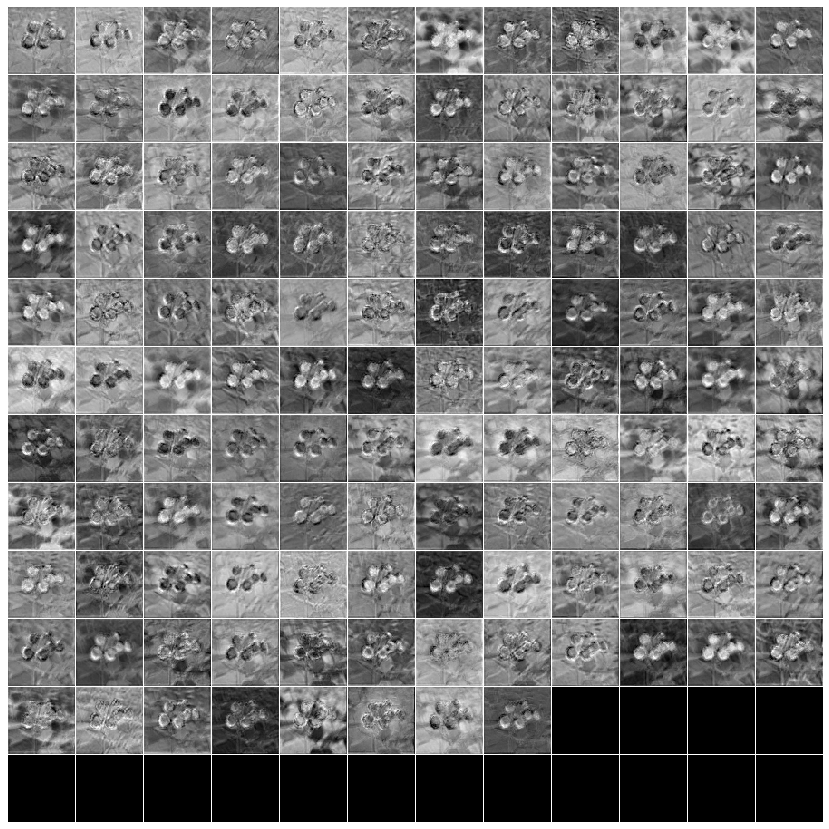

In [133]:
view_feature_map(load_layer(conv2, new_img))

(1, 75, 75, 128)


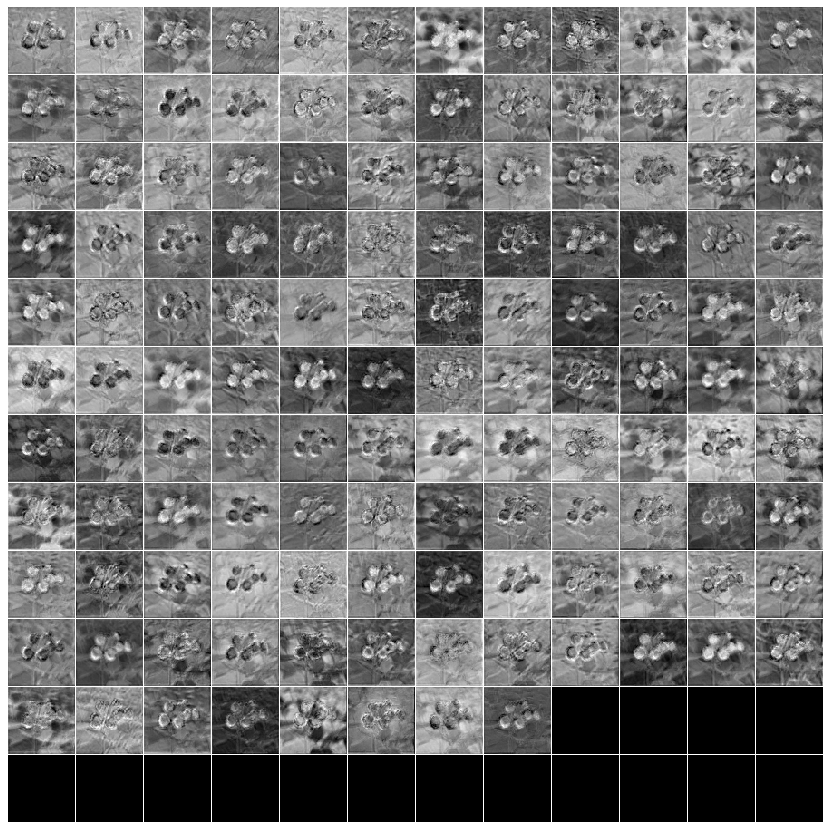

In [134]:
view_feature_map(load_layer(batch_norm2, new_img))

(1, 75, 75, 128)


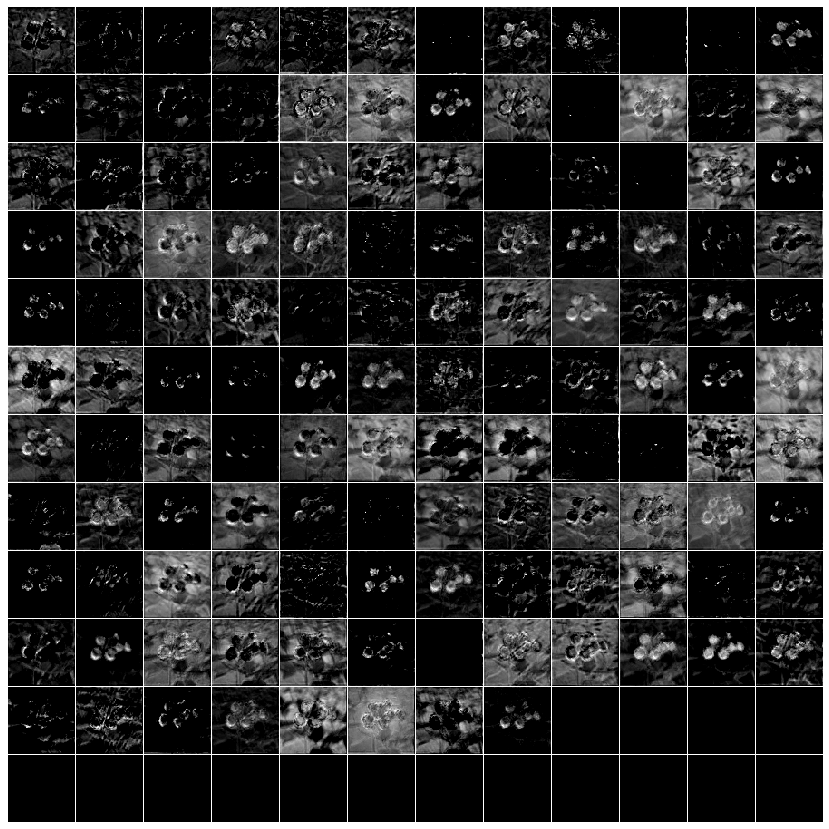

In [135]:
view_feature_map(load_layer(relu2, new_img))

(1, 38, 38, 128)


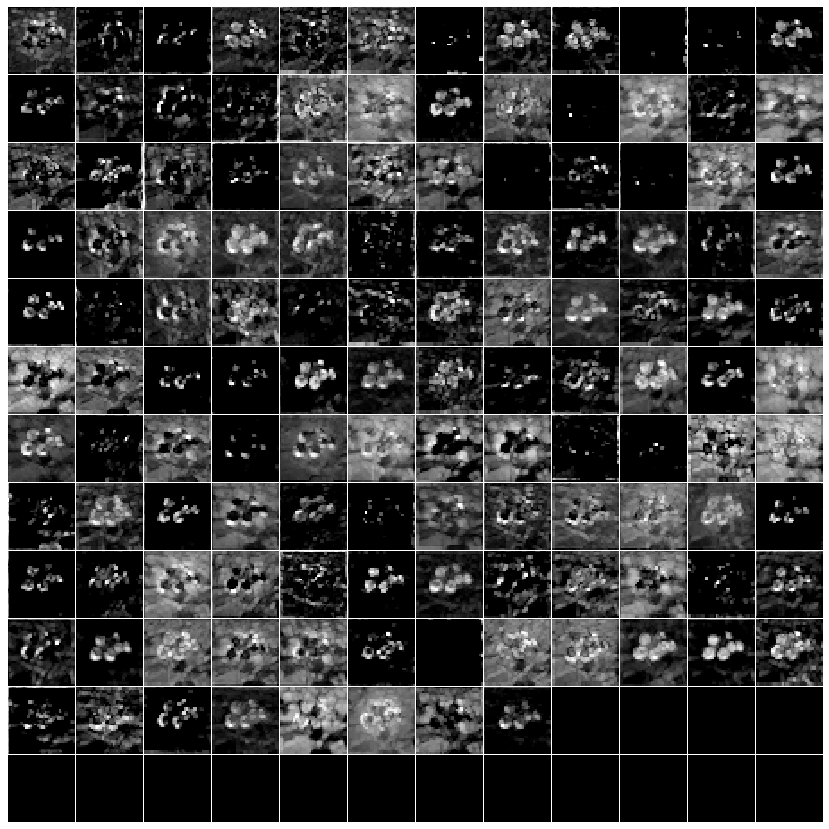

In [136]:
view_feature_map(load_layer(pool2, new_img))

(1, 38, 38, 256)


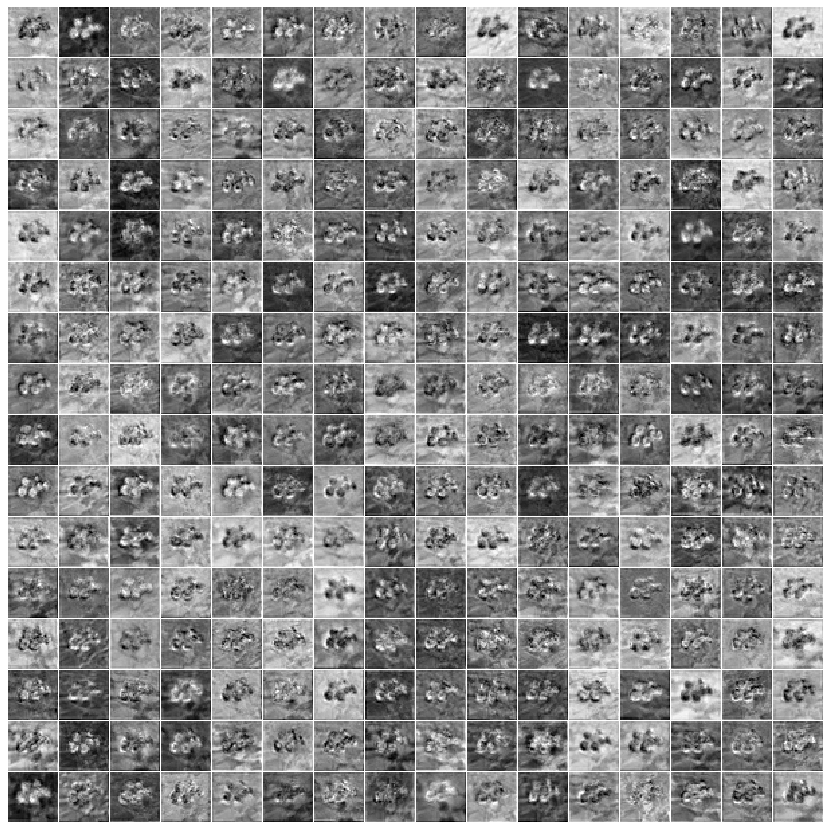

In [137]:
view_feature_map(load_layer(conv3, new_img))

(1, 38, 38, 256)


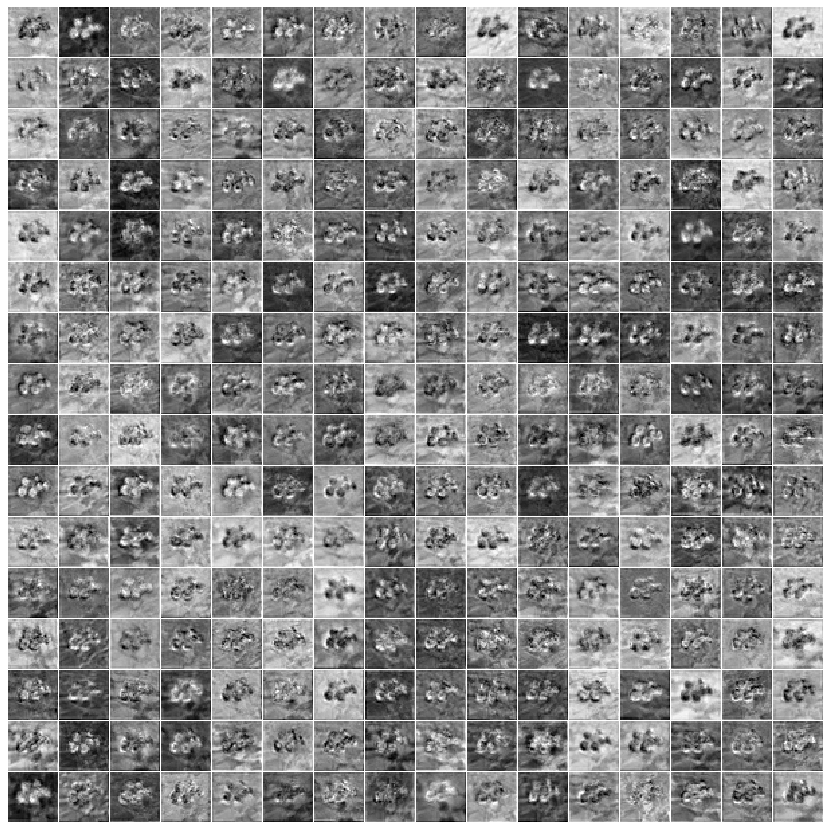

In [138]:
view_feature_map(load_layer(batch_norm3, new_img))

(1, 38, 38, 256)


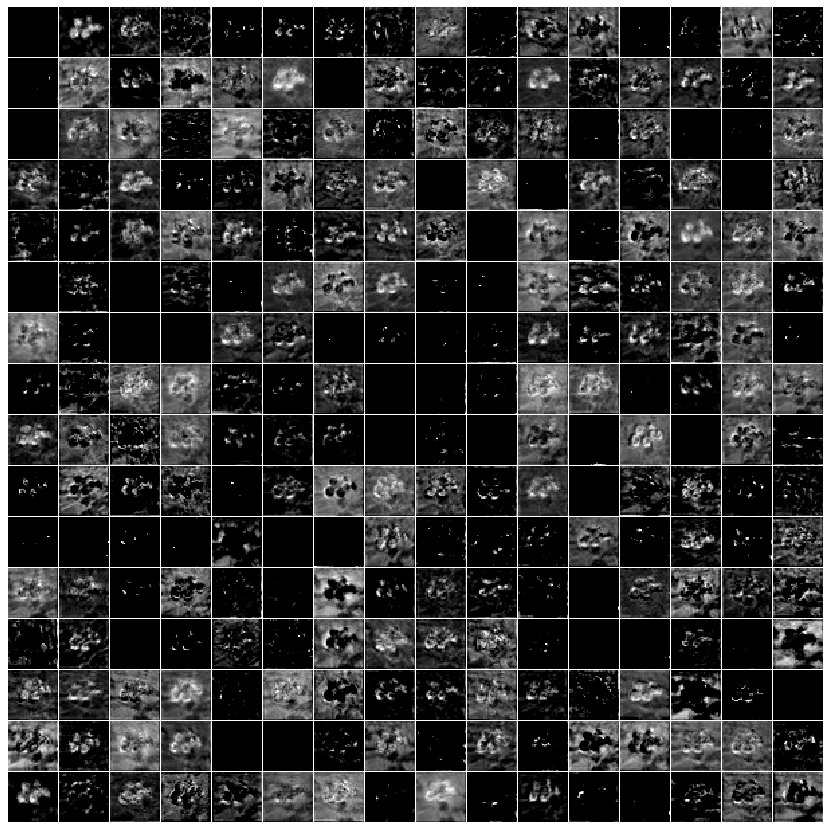

In [139]:
view_feature_map(load_layer(relu3, new_img))

Each convolutional layer is the basis for which the neural network will be built. When comparing each convolutional layer feature map, it seems as though the colors have been inverted, which allows for new features to be processed by the system. The relu layers are involved with nonlinear properties. Each layer is brought into a pooling layer which combines the features and output the maximum, also reducing spatial size with each layer.